In [2]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from itertools import product

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from scipy.stats import mode

I pulled and cleaned a comprehensive dataset of colleges from this governmental database:
    
https://collegescorecard.ed.gov/data/

Let's read this dataset in:

In [3]:
df = pd.read_csv('data/schools.csv', index_col = 0)
print(df.shape)
df.head()

(6740, 46)


,name,ownership,ope6_id,state,size,accreditor,retention,branches,online_only,religious_affil,...,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,Alaska Bible College,2,8843,AK,27,Association for Bibical Higher Educaiton,0.333300,1,0,88.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
1,Alaska Christian College,2,41386,AK,68,Association for Bibical Higher Educaiton,0.473700,1,0,37.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
2,Ilisagvik College,1,34613,AK,109,Northwest Commission on Colleges and Universities,0.809500,1,0,-2.0,...,0.463652,0.699542,0.496850,0,1,1,1,0,0,0
3,Charter College-Anchorage,3,25769,AK,3256,Accrediting Council for Independent Colleges a...,0.703723,1,0,-2.0,...,0.310288,0.725806,0.417949,0,1,0,1,1,1,1
4,Alaska Career College,3,25410,AK,479,Accrediting Commission of Career Schools and C...,0.794100,1,0,-2.0,...,0.254237,0.556430,0.462520,0,1,1,1,1,1,1


We are going to use classification algorithms to try to predict for-profit or non-profit status. 

Some of the categories aren't applicable to what we want to do so let's consider the following columns only:


In [4]:
X = df[['size','retention','branches', 'online_only', 'under_investigation', 'most_common_degree', 'highest_degree',
       'faculty_salary', 'instructional_expenditure_per_fte',
       'tuition_revenue_per_fte', 'part_time_share',
       'age_entry', 'percent_dependent', 'first_generation', 'percent_black',
        'avg_family_income','ind_low_income', 'dep_low_income', 'loan_principal',
       'federal_loan_rate', 'students_with_any_loans',
       'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n', 'for_profit']]
X.head()

,size,retention,branches,online_only,under_investigation,most_common_degree,highest_degree,faculty_salary,instructional_expenditure_per_fte,tuition_revenue_per_fte,...,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,27,0.333300,1,0,0,3,3,2201,9585,8132,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
1,68,0.473700,1,0,0,1,2,5554,18174,12989,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
2,109,0.809500,1,0,0,1,2,6054,38265,3587,...,0.463652,0.699542,0.496850,0,1,1,1,0,0,0
3,3256,0.703723,1,0,0,1,3,4004,2617,8755,...,0.310288,0.725806,0.417949,0,1,0,1,1,1,1
4,479,0.794100,1,0,0,1,2,3861,4178,11905,...,0.254237,0.556430,0.462520,0,1,1,1,1,1,1


Let's first use a method called [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) to see which features have the most statistically significant relationships with profit status. The **lower** the p value, the **more** statistically significant:

In [5]:
y = X.pop('for_profit')

X_new = SelectKBest(chi2, k=2).fit(X, y)

features = []
for i, column in enumerate(X.columns):
    features.append((X_new.pvalues_[i], column))
features.sort()
print('chi2-value', 'feature')
features

chi2-value feature


[(0.0, 'avg_family_income'),
 (0.0, 'branches'),
 (0.0, 'faculty_salary'),
 (0.0, 'instructional_expenditure_per_fte'),
 (0.0, 'loan_principal'),
 (0.0, 'pell_grant_debt'),
 (0.0, 'size'),
 (0.0, 'tuition_revenue_per_fte'),
 (5.339096890496358e-283, 'highest_degree'),
 (2.3550018048916394e-222, 'most_common_degree'),
 (5.4025502611485345e-149, 'fac_salary_listed_y_n'),
 (8.240679129762035e-148, 'relig_y_n'),
 (5.293172158552389e-143, 'age_entry'),
 (1.4125160311605584e-48, 'percent_dependent'),
 (1.4293811306586728e-24, '5_year_declining_balance'),
 (1.3527931483012968e-21, 'federal_loan_rate'),
 (6.095800240149601e-17, 'percent_black'),
 (3.249757484509366e-15, 'fafsa_sent'),
 (2.3099399670297893e-10, '7_yr_repayment_completion'),
 (5.332261659651424e-09, 'first_generation'),
 (1.407934457452164e-08, 'part_time_share'),
 (1.516370320447573e-08, 'dep_low_income'),
 (5.389960032435474e-08, 'percent_pell_grant'),
 (2.9423628117768117e-06, 'students_with_any_loans'),
 (9.035892891499908e-

1.Based on the info above, what was intuitive? What was surprising? How big (or small) of an effect does accredition have on for-profit status? What might be some guesses as to why this is the case?

It's intuitive that loan repayment would indicate for-profit college or nonprofit. Generally, attending a for-profit college is not only expensive  but a lower educational value, meaning it would be harder for most students to repay loans because they make less money in worse jobs. Additionally, to obtain specific (and more lenient) student loans or Pell Grants, a college must be accredited, which likely contributes to the high correlations with accreditation and repayment completion. Retention also makes sense: for-profit colleges generally have a reputation of low graduation rates due to the expense and the nature of the students. 

2.Do a test/train split and give the testing accuracy error for logistic regression.

In [6]:
X = df[['size','retention','branches', 'online_only', 'under_investigation', 'most_common_degree', 'highest_degree',
       'faculty_salary', 'instructional_expenditure_per_fte',
       'tuition_revenue_per_fte', 'part_time_share',
       'age_entry', 'percent_dependent', 'first_generation', 'percent_black',
        'avg_family_income','ind_low_income', 'dep_low_income', 'loan_principal',
       'federal_loan_rate', 'students_with_any_loans',
       'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n', 'for_profit']]

y = X['for_profit']
X = X.drop(columns = ['for_profit'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

3.Find the optimal number of nearest neighbors for KNN using grid search and then give the test accuracy. 

In [7]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

from sklearn.model_selection import GridSearchCV

# create a parameter grid: map the parameter names to the values that should be searched
# Grid search uses all the parameters

param_grid = {'n_neighbors': range(1, 20)}

model = GridSearchCV(KNeighborsClassifier(), 
                    param_grid, 
                    cv=3, 
                    scoring='accuracy')

model = model.fit(X_train, y_train)

print(model.best_params_, model.best_estimator_)

model = model.best_estimator_

print(model.score(X_test, y_test))

{'n_neighbors': 3} KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')


0.933728981206726


4.Run a classification report and describe in detail what the terms mean in the context of your model.

In [8]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1150
           1       0.91      0.94      0.92       872

    accuracy                           0.93      2022
   macro avg       0.93      0.93      0.93      2022
weighted avg       0.93      0.93      0.93      2022



The accuracy of the model was 93%, meaning 93% of its predictions were correct, and 7% were incorrect.

With a precision score of 95%, out of all colleges predicted as non-profit, we were correct 95% of the time. With a recall score of 93%, out of all non-profit colleges, we found 93% of them.

With a precision score of 91%, out of all colleges predicted as for-profit, we were correct 91% of the time. With a recall score of 94%, out of all for-profit colleges, we found 94% of them.

5.Print a confusion matrix and describe what it means in your context.

In [9]:
confusion_matrix(y_test, model.predict(X_test))

array([[1072,   78],
       [  56,  816]])

Confusion Matrix Analysis

6.Make a comparative ROC plot of the naive bayes, logistic, gradient boosting, and KNN classifiers.

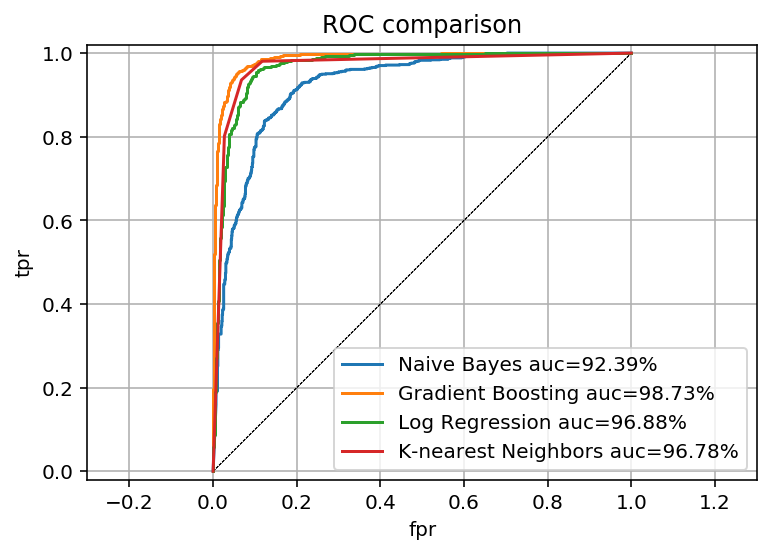

In [10]:
y_proba_KNN = model.predict_proba(X_test)[:, 1]

model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)
model.fit(X_train, y_train)
y_proba_LR = model.predict_proba(X_test)[:, 1]

model = GradientBoostingClassifier()
model.fit(X_train, y_train)

y_proba_GB = model.predict_proba(X_test)[:, 1]

model = naive_bayes.GaussianNB()
model.fit(X_train, y_train)
   
y_proba_NB = model.predict_proba(X_test)[:, 1]

def plot_roc(ytrue, yproba, model, title='ROC comparison'):
    auc = roc_auc_score(ytrue, yproba)
    fpr, tpr, thr = roc_curve(ytrue, yproba)
    plt.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4)
    plt.plot(fpr, tpr, label='{} auc={:.2f}%'.format(model, auc*100))
    plt.axis('equal')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)

plot_roc(y_test, y_proba_NB, "Naive Bayes")
plot_roc(y_test, y_proba_GB, "Gradient Boosting")
plot_roc(y_test, y_proba_LR, "Log Regression")
plot_roc(y_test, y_proba_KNN, "K-nearest Neighbors")

In [11]:
X = df[['size','retention','branches', 'online_only', 'under_investigation', 'most_common_degree', 'highest_degree',
       'faculty_salary', 'instructional_expenditure_per_fte',
       'tuition_revenue_per_fte', 'part_time_share',
       'age_entry', 'percent_dependent', 'first_generation', 'percent_black',
        'avg_family_income','ind_low_income', 'dep_low_income', 'loan_principal',
       'federal_loan_rate', 'students_with_any_loans',
       'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n', 'for_profit']]

7.Using the logarithmic regression model, plot a decision boundary between instructional_expenditure_per_fte and 5_year_declining_balance. Does it appear that for-profit status has a clear boundary based on these predictors?

(-2.941558886777559, 3.1784411132224464)

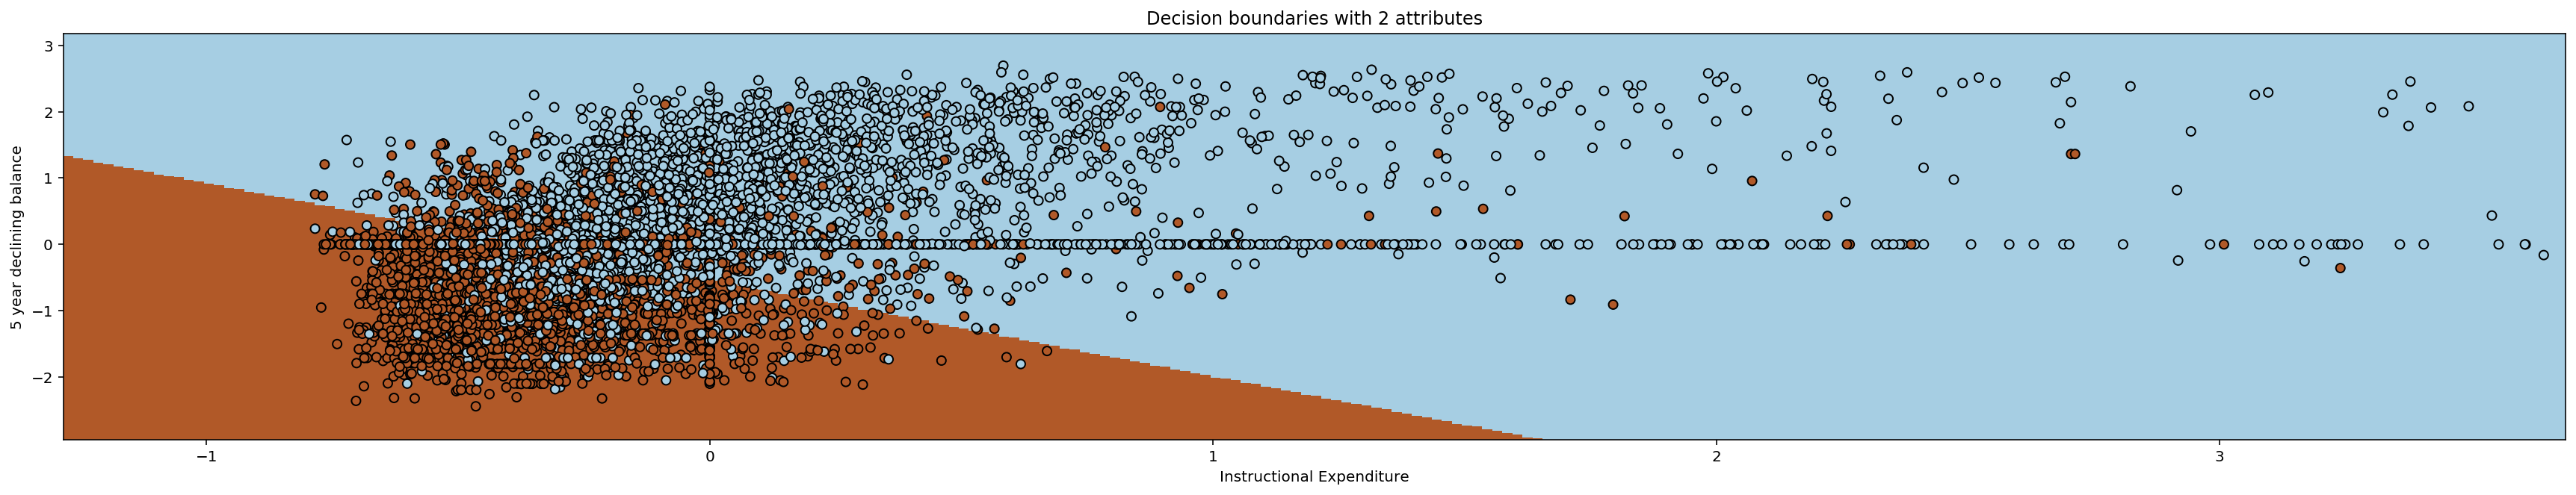

In [12]:

Xi = X[['instructional_expenditure_per_fte','5_year_declining_balance']]

X_scaler = StandardScaler()
Xi = X_scaler.fit_transform(Xi)
Xi = pd.DataFrame(Xi)

model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)

Q = Xi.values

h = .02  # meshsize
x_min, x_max = Q[:, 0].min() - .5, Q[:, 0].max() + .5 
y_min, y_max = Q[:, 1].min() - .5, Q[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
model.fit(Xi.iloc[:,:2], y)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) # ravel() flattens the data

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(30, 5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(Q[:, 0], Q[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Decision boundaries with 2 attributes')
plt.xlabel('Instructional Expenditure')
plt.ylabel('5 year declining balance')

plt.xlim(xx.min(), xx.max()*0.1)

plt.ylim(yy.min(), yy.max())

Decision Boundary Analysis

8.We have not covered random forests but they are a very popular type of classifier. It is very good practice in reading the docs to get a new classifier working. Read [this](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and then apply the RandomForestClassifier().

In [13]:
model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

model.fit(X_train, y_train)  

print(model.feature_importances_)

model.score(X_test,y_test)

y_proba_RFC = model.predict_proba(X_test)[:, 1]

[0.11559996 0.0017697  0.0400806  0.         0.         0.09870857
 0.12735175 0.05551812 0.05445811 0.01619788 0.00985808 0.01041531
 0.08466746 0.01280006 0.00039138 0.07386039 0.00110552 0.0041997
 0.0015289  0.04024858 0.02363439 0.00367579 0.01170861 0.04260015
 0.02690415 0.04790588 0.00904447 0.00063236 0.         0.08472535
 0.         0.00040879]


9.Support vector machines are another type of classifier. Read the docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and then try implementing that one.

In [14]:
model = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto_deprecated', coef0=0.0, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', random_state=None)

model.fit(X_train, y_train)

print(model.score(X_test,y_test))

y_proba_SVM = model.predict_proba(X_test)[:, 1]

0.9436201780415431


10. Make a comparative ROC plot of the naive bayes, logistic, gradient boosting, KNN classifiers, random forest, and SVM classifiers.

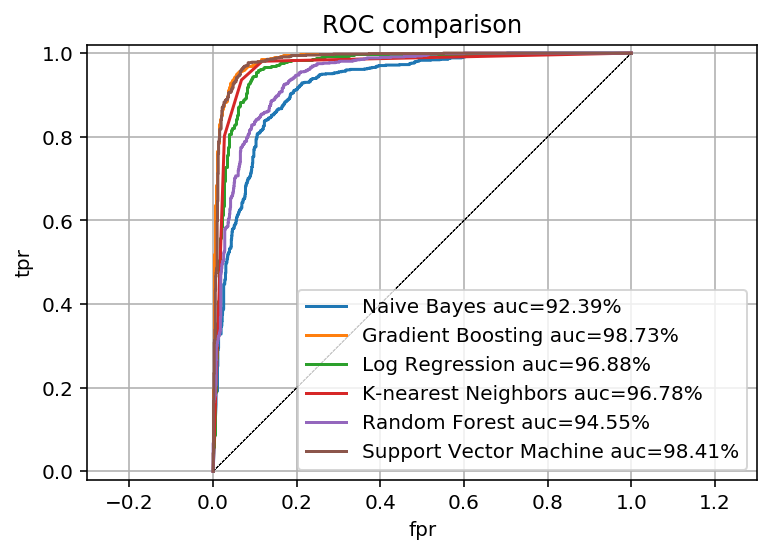

In [15]:
def plot_roc(ytrue, yproba, model, title='ROC comparison'):
    auc = roc_auc_score(ytrue, yproba)
    fpr, tpr, thr = roc_curve(ytrue, yproba)
    plt.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4)
    plt.plot(fpr, tpr, label='{} auc={:.2f}%'.format(model, auc*100))
    plt.axis('equal')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)

plot_roc(y_test, y_proba_NB, "Naive Bayes")
plot_roc(y_test, y_proba_GB, "Gradient Boosting")
plot_roc(y_test, y_proba_LR, "Log Regression")
plot_roc(y_test, y_proba_KNN, "K-nearest Neighbors")
plot_roc(y_test, y_proba_RFC, "Random Forest")
plot_roc(y_test, y_proba_SVM, "Support Vector Machine")

11.Take in a new school's data and predict the school's profit status using one of your previous classifier methods.

In [16]:
model = GradientBoostingClassifier()
model.fit(X_train,y_train)

print(model.predict([X_test.iloc[2]]))
print(y_test.iloc[2])

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

12.What are the worst schools? Some of them are chains of schools so don't necessarily consider singular names but generalize to chains. Give a lot of justification for your analysis as everyone might have a different answer here. Insert these responses into your blog.

In [27]:
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.head()
X_scaled.columns = X.columns

Score = X_scaled.assign(Score = lambda x:
                X_scaled['retention'] + 5*X_scaled['7_yr_repayment_completion']+X_scaled['instructional_expenditure_per_fte']+X_scaled['accred_y_n']
                        )
Score["Rank"] = Score["Score"].rank(ascending = True)
names = df[['name']]
Score = Score.join(names)
Score = Score.sort_values(by = 'Rank', ascending = False)
Score = Score.assign(Rank = lambda x: Score['Rank'])
Score.tail(15)

,size,retention,branches,online_only,under_investigation,most_common_degree,highest_degree,faculty_salary,instructional_expenditure_per_fte,tuition_revenue_per_fte,...,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit,Score,Rank,name
4489,-0.463466,1.190392e+00,-0.302187,-0.075299,-0.101702,-0.830804,-0.956915,-0.000157,-0.380420,-0.811165,...,-0.388784,-8.694303,0.486049,-1.266621,0.811207,0.536867,-0.870343,-18.122575,15.0,NaN
5904,-0.342707,-1.029977e+00,-0.004084,-0.075299,-0.101702,-0.830804,-0.197423,-1.341153,-0.304537,0.072858,...,-0.388784,-8.694303,0.486049,0.789502,0.811207,0.536867,1.148972,-18.464584,14.0,Stroudsburg School of Cosmetology
5914,-0.328639,-1.136688e+00,0.194651,-0.075299,-0.101702,-0.830804,-0.956915,-0.000157,-0.300275,0.071926,...,-0.388784,0.115018,0.486049,-1.266621,0.811207,0.536867,1.148972,-18.468381,13.0,Reformed Presbyterian Theological Seminary
1937,-0.381985,-1.386753e+00,-0.202819,-0.075299,-0.101702,-0.830804,-0.956915,-0.000157,-0.556301,-0.092191,...,-0.388784,-8.694303,0.486049,-1.266621,0.811207,0.536867,1.148972,-18.612893,12.0,Armstrong State University
5474,-0.447572,-9.521935e-01,-0.103451,-0.075299,-0.101702,-0.830804,-0.956915,-0.000157,0.250863,-0.052267,...,-0.388784,0.115018,0.486049,-1.266621,0.811207,0.536867,1.148972,-18.695881,11.0,NaN
1245,-0.397697,-5.806321e-01,0.095284,-0.075299,-0.101702,-0.830804,-0.956915,-0.000157,-0.483745,0.765992,...,-0.388784,-8.694303,0.486049,-1.266621,0.811207,0.536867,1.148972,-19.248047,10.0,NaN
4569,-0.398793,7.850651e-15,-0.103451,-0.075299,-0.101702,-0.830804,-0.956915,-0.000157,-0.312437,-0.097080,...,-0.388784,-8.694303,-2.057406,-1.266621,0.811207,0.536867,1.148972,-19.853191,9.0,Carrington College-Reno
5618,-0.454514,-1.409297e-01,-0.302187,-0.075299,-0.101702,-0.830804,-0.956915,-0.000157,-0.205681,0.212881,...,-0.388784,0.115018,0.486049,-1.266621,0.811207,0.536867,1.148972,-19.918288,8.0,NaN
5891,-0.329370,-5.619897e-01,-0.202819,-0.075299,-0.101702,-0.830804,-0.956915,-0.000157,-0.361397,-0.072520,...,-0.388784,-8.694303,0.486049,-1.266621,0.811207,0.536867,1.148972,-19.927855,7.0,Brightwood Career Institute-Broomall
5899,-0.380524,-8.126972e-01,-0.202819,-0.075299,-0.101702,-0.830804,-0.197423,-0.000157,-0.286242,-0.124083,...,-0.388784,-8.694303,0.486049,-1.266621,0.811207,0.536867,1.148972,-20.242348,6.0,Slippery Rock University of Pennsylvania


13.If you were a governmental organization overseeing accreditation, what factors would be most important to you in making sure that the college was non-predatory? Give a lot of detail here as well in your blog.

In [0]:
#insert 13

14.Read several articles on college predatory practices and cite and incorporate them into your blog discussion. Remember to link to them clearly by using the 
```[here](http://....)``` syntax.